# K-Means Clustering

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import fcluster

import itertools

In [3]:
dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
dataset.info()

FileNotFoundError: [Errno 2] No such file or directory: '../data/complete_dataset_fe.csv'

In [ ]:
columns_to_use = ['mean_cp', 'mean_position', 'mean_delta'] # we need to accumulate the features values in the dataset, so to have only one per cyclist

# the cyclist_climb_power attribute is instead accumulated respect to a weighted mean based on the climb_percentage of each record (we need to give less weight to less steep profiles)
weighted_mean_cp = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['cyclist_climb_power'] * group['climb_percentage']).sum() / group['climb_percentage'].sum()
    )
)

# the delta attribute is accumulated with a weighted mean based on the number of records (we dont want more representeed cyclists to be penalized)
group_sizes = dataset.groupby('cyclist_url').size()
dataset['group_size'] = dataset['cyclist_url'].map(group_sizes)
weighted_mean_delta = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['delta'] * group['group_size']).sum() / group['group_size'].sum()
    )
)

# the position attribute is accumulated with a weighted mean based on the number of records (we dont want more representeed cyclists to be penalized)
weighted_mean_pos = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['position'] * group['group_size']).sum() / group['group_size'].sum()
    )
)

# we map the means calculated back to each row
dataset['mean_delta'] = dataset['cyclist_url'].map(weighted_mean_delta)
dataset['mean_position'] = dataset['cyclist_url'].map(weighted_mean_pos)
dataset['mean_cp'] = dataset['cyclist_url'].map(weighted_mean_cp)


dataset = dataset[['cyclist_url', 'mean_cp', 'mean_position', 'mean_delta']].drop_duplicates()
dataset = dataset[columns_to_use]

/var/folders/6w/jr75hz4j1mnfxpxpb_7px5b40000gn/T/ipykernel_2871/3193795502.py:6: RuntimeWarning: invalid value encountered in scalar divide
  lambda group: (group['cyclist_climb_power'] * group['climb_percentage']).sum() / group['climb_percentage'].sum()
/var/folders/6w/jr75hz4j1mnfxpxpb_7px5b40000gn/T/ipykernel_2871/3193795502.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset.groupby('cyclist_url').apply(
/var/folders/6w/jr75hz4j1mnfxpxpb_7px5b40000gn/T/ipykernel_2871/3193795502.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Eithe

In [ ]:
# Gestione dei valori mancanti
data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

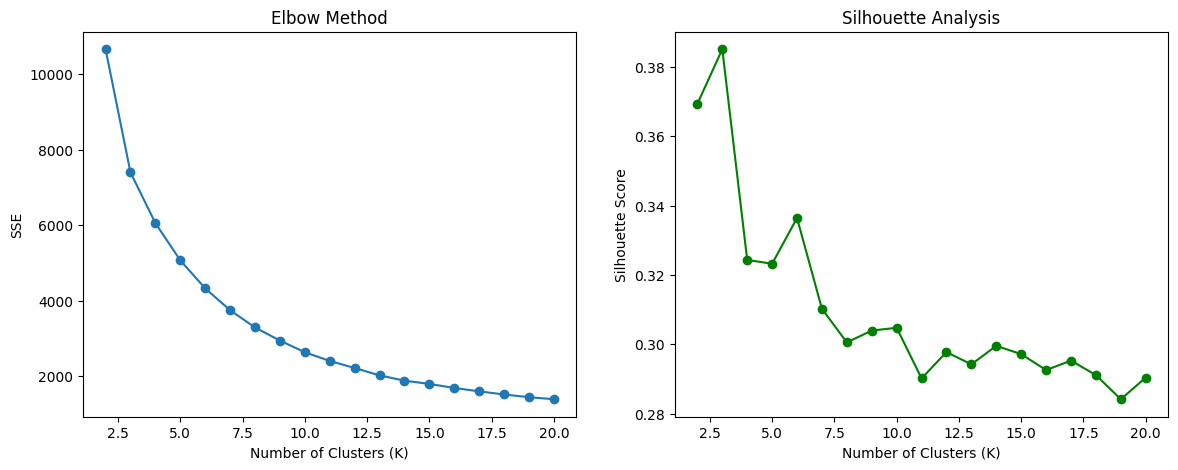

In [ ]:
sse_list = []
silhouette_scores = []
max_k = 20

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(data_scaled)
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Visualizzazione del metodo del gomito
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), sse_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.title('Elbow Method')

# Visualizzazione del Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [ ]:
# Applicazione del K-Means
n_clusters = 3  # Puoi modificare il numero di cluster
kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=42)
kmeans.fit(data_scaled)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=42)

In [ ]:
# Etichette dei cluster e centroidi
cluster_labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Aggiunta delle etichette al dataset originale
data_for_clustering['cluster'] = cluster_labels

# Calcolo punteggi di valutazione
print(f"SSE (Sum of Squared Errors): {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_score(data_scaled, cluster_labels)}")


/var/folders/6w/jr75hz4j1mnfxpxpb_7px5b40000gn/T/ipykernel_2871/1747060433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = cluster_labels


SSE (Sum of Squared Errors): 7399.538273904815
Silhouette Score: 0.3851233152310693


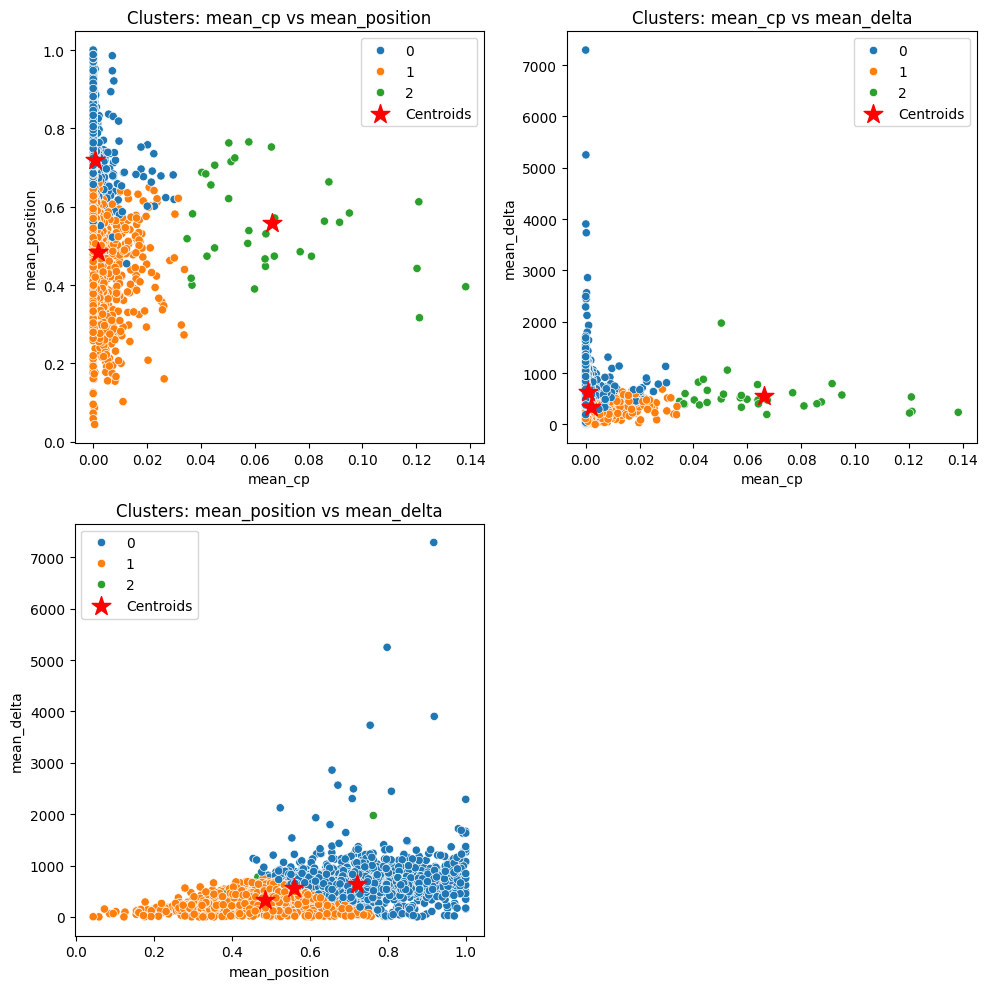

In [ ]:
# Visualizzazione con scatterplot per ogni coppia di feature

# Creazione di tutte le combinazioni di coppie di variabili
pairs = list(itertools.combinations(columns_to_use, 2))
n_pairs = len(pairs)

# Dimensione della griglia (calcolata in base al numero di coppie)
n_cols = 2  # Numero di colonne nella griglia
n_rows = int(np.ceil(n_pairs / n_cols))  # Numero di righe nella griglia

# Creazione della griglia di subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

# Se c'è una sola riga di subplot, axes sarà un array 1D; uniformiamo la struttura.
if n_rows == 1:
    axes = axes[np.newaxis, :]

# Plot per ogni coppia di variabili
for (x_var, y_var), ax in zip(pairs, axes.ravel()):
    sns.scatterplot(
        data=data_for_clustering,
        x=x_var, y=y_var, hue="cluster", palette="tab10", ax=ax
    )
    ax.scatter(
        scaler.inverse_transform(centers)[:, columns_to_use.index(x_var)],
        scaler.inverse_transform(centers)[:, columns_to_use.index(y_var)],
        s=200, c='red', marker='*', label='Centroids'
    )
    ax.set_title(f'Clusters: {x_var} vs {y_var}')
    ax.legend()

# Rimuovi subplot vuoti se n_pairs non riempie la griglia
for ax in axes.ravel()[n_pairs:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


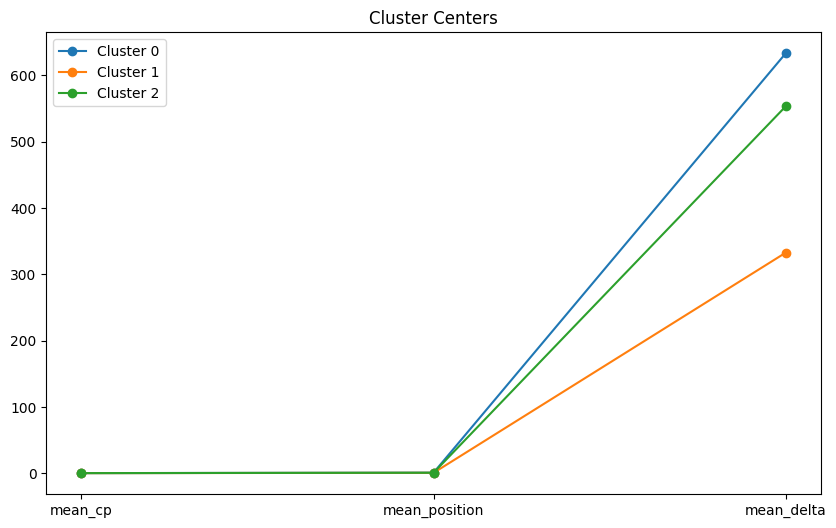

In [ ]:
# Centroidi riportati alle scale originali
centers_original = scaler.inverse_transform(centers)

# Visualizzazione parallela dei centroidi
plt.figure(figsize=(10, 6))
for i in range(len(centers_original)):
    plt.plot(centers_original[i], marker='o', label=f'Cluster {i}')
plt.xticks(range(len(columns_to_use)), columns_to_use)
plt.title('Cluster Centers')
plt.legend()
plt.show()


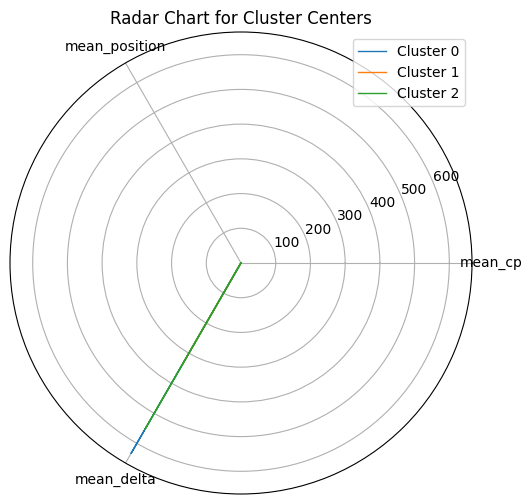

In [ ]:
from math import pi

N = len(columns_to_use)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Radar Chart per ogni cluster
plt.figure(figsize=(10, 6))
for i, center in enumerate(centers_original):
    values = center.tolist()
    values += values[:1]
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], columns_to_use)
plt.title('Radar Chart for Cluster Centers')
plt.legend()
plt.show()


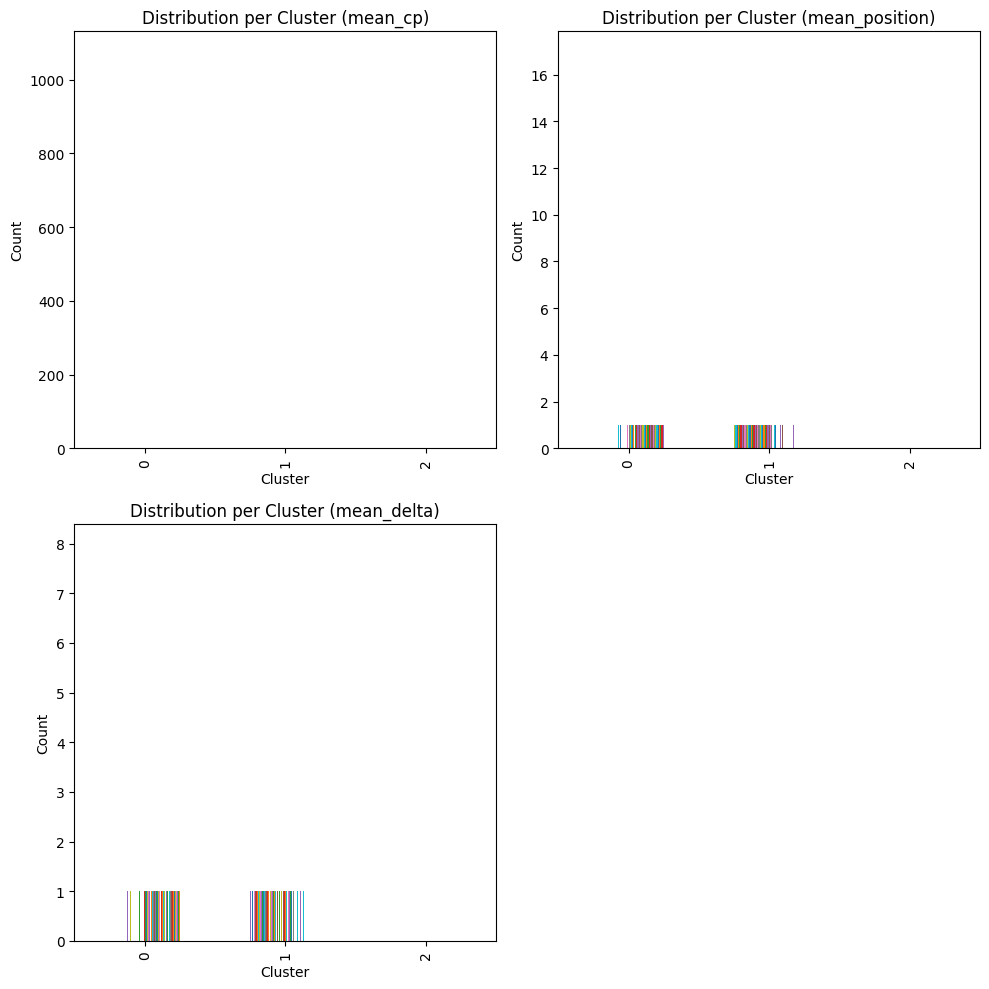

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lista delle variabili da plottare
columns_to_use = ['mean_cp', 'mean_position', 'mean_delta']

# Creazione della griglia basata sulla dimensione di columns_to_use
n_cols = 2  # Numero di colonne nella griglia
n_rows = int(np.ceil(len(columns_to_use) / n_cols))  # Calcola il numero di righe necessarie

# Creazione della griglia di subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

# Se c'è una sola riga di subplot, assicuriamo che `axes` sia un array bidimensionale
if n_rows == 1:
    axes = np.array([axes])

# Loop attraverso le variabili e i subplot
for col, ax in zip(columns_to_use, axes.ravel()):
    # Crea la tabella di contingenza
    cross_df = pd.crosstab(kmeans.labels_, data_for_clustering[col])
    
    # Plot nel subplot corrente
    cross_df.plot(kind='bar', stacked=False, ax=ax, legend=False)
    ax.set_title(f'Distribution per Cluster ({col})')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')

# Rimuove eventuali subplot vuoti (se len(columns_to_use) < n_rows * n_cols)
for ax in axes.ravel()[len(columns_to_use):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [ ]:
columns_to_use = ['mean_cp', 'mean_position', 'mean_delta']

dataset = dataset[dataset['race_name'] == 'Ronde van Vlaanderen']
columns_to_use = ['length','race_prestige', 'race_physical_effort', 'cyclist_bmi', 'cyclist_age', 'height', 'cyclist_climb_power', 'position', 'delta']